In [1]:
import os
import sys
sys.path.append(f"{os.environ['base']}Tools")

import btk
import cv2 as cv
import dataset_generators as dgen
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image, ImageDraw
from tensorflow import keras
from tensorflow.keras import layers

tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)
plt.style.use(f"{os.environ['style']}")


In [ ]:
#Demo set
dtimg = dgen.bg_words(1, 1, dgen.trainfonts)
dtx, dty = dgen.binary_text(dtimg, True)
display(Image.fromarray(dtimg[0][0]))

for x in range(len(dtx)):
    display(Image.fromarray(dtx[x]))
    display(dty[x])

In [ ]:
#trainx, trainy, valx, valy = btk.depickler('trainx-1643898308', 'trainy-1643898308', 'valx-1643898308', 'valy-1643898308', 'ocr')

""" trainx, trainy = dgen.binary_text(dgen.bg_words(27000, 1, dgen.trainfonts), True)
valx, valy = dgen.binary_text(dgen.bg_words(9000, 1, dgen.evalfonts), False)
btk.pickle_set(trainx, trainy, valx, valy, 'ocr') """

In [ ]:
tgen = btk.DataGen(trainx, trainy, 96)
vgen = btk.DataGen(valx, valy, 32)


inlay = keras.Input(shape=(64, 64, 1))
x = layers.Rescaling(1.0/255)(inlay)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.1)(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.1)(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.1)(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.1)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = layers.Dropout(0.36)(x)
outlay = layers.Dense(1, activation='sigmoid')(x)


log_dir = "tblogs/detection/3/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tbcall = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
estop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20, restore_best_weights=False)
opti = keras.optimizers.Adam(learning_rate=0.001)
tdetect = keras.Model(inlay, outlay, name='tdetect')
tdetect.compile(optimizer=opti, loss='binary_crossentropy', metrics=['accuracy'])
history = tdetect.fit(
    x = tgen,
    validation_data=vgen,
    epochs=64,
    steps_per_epoch=32,
    validation_steps=32,
    callbacks=[estop, tbcall],
    verbose=0
)

hist = pd.DataFrame(history.history)
hist[['accuracy', 'val_accuracy']].plot()
display(hist['val_accuracy'].max())
display(hist['val_loss'].min())

In [ ]:
#tdetect.save('models\\tdetect-1')
#tdetect = tf.keras.models.load_model('models\\tdetect-1')
#tdetect.summary()

In [ ]:
#tdetect = tf.keras.models.load_model('models\\tdetect')

def predictor(img: Image, dims: tuple[int, int], step: tuple[int, int], sensitivity: float = 0.95) -> list:
    slices, slice_coords = btk.img_slicer(img, dims, step, 'm')
    answers = tdetect.predict(btk.DataGen(slices))
    answer_coords = [list(slice_coords[x]) for x in range(len(answers)) if answers[x] > sensitivity]
    return answer_coords

def predict(img: Image, dims: tuple, sdims: tuple, step: int, sens: float, olr:float) -> list:
    resized = btk.img_splitter(img, dims, sdims)
    ygap = int(sdims[0] / 2)
    xgap = int(sdims[1] / 2)
    sum_coords = []
    for x in resized:
        text_coords = predictor(x, sdims, step, sens)
        for y in text_coords:
            sum_coords.append(y)
    predictions = coord_split(sum_coords, ygap, xgap, olr)
    return predictions

def detected_heat(img: Image, dims:tuple[int, int], sdims: tuple, step: int, sens:float)-> Image: 
    heatmap = np.zeros(dims, dtype=np.uint8)
    resized = btk.img_splitter(img, dims)
    for x in resized:
        text_coords = predictor(x, sdims, step, sens)
        yscale, xscale = dims[0] / x.shape[0], dims[1] / x.shape[1]
        scaled_coords = [[round(z[0] * yscale), round(z[1] * yscale), round(z[2] * xscale), round(z[3] * xscale)] for z in text_coords]
        for z in scaled_coords:
            heatmap[z[0]:z[1], z[2]:z[3]] = heatmap[z[0]:z[1], z[2]:z[3]] + np.ones((z[1] - z[0], z[3] - z[2]))
    return Image.fromarray(heatmap)


def coord_sort(cords):
    temp1 = []
    temp2 = []
    temp3 = []
    for i, x in enumerate(cords):
        if x == cords[-1]:
            break
        while x[1] != cords[i + 1][0] or x[3] < cords[i + 1][2] or cords[i + 1][3] < x[2]:
            temp1.append(cords.pop(i + 1))
            if x == cords[-1]:
                break
    for i, x in enumerate(temp1):
        if x == temp1[-1]:
            break
        while x[1] != temp1[i + 1][0] or x[3] < temp1[i + 1][2] or temp1[i + 1][3] < x[2]:
            temp2.append(temp1.pop(i + 1))
            if x == temp1[-1]:
                break
    for i, x in enumerate(temp2):
        if x == temp2[-1]:
            break
        while x[1] != temp2[i + 1][0] or x[3] < temp2[i + 1][2] or temp2[i + 1][3] < x[2]:
            temp3.append(temp2.pop(i + 1))
            if x == temp2[-1]:
                break
    final = [*cords, *temp1, *temp2, *temp3]
    return final

def coord_split(coords: list, ygap: int, xgap: int, olr) -> list:
    split_coords = []
    for x in coords:
        split_coords.append((x[0], x[0] + ygap, x[2], x[2] + xgap))
        split_coords.append((x[0] + ygap, x[1], x[2] + xgap, x[3]))
        split_coords.append((x[0], x[0] + ygap, x[2], x[2] + xgap))
        split_coords.append((x[0] + ygap, x[1], x[2] + xgap, x[3]))
    split_coords = [x for x in btk.count(split_coords)]
    split_coords = [x[0] for x in split_coords if x[1] >= round(max([x[1] for x in split_coords]) * olr)]
    return split_coords

def is_touch(cord1: tuple, coords:list[tuple]) -> list:
    temp = set()
    for x in coords:
        if cord1[3] < x[2] or x[3] < cord1[2] or cord1 == x:
            pass
        elif cord1[0] != x[1] and cord1[1] != x[0]:
            pass
        else:
            temp.add(x)
    return list(temp)

def hbox_combo(coords: list, gap: int) -> list:
    y_rows = {x[0] for x in coords}
    row_boxes = []
    for x in y_rows:
        tmp1 = {i for i in coords if i[0] == x}
        tmp2 = {j[2]:j[3] for j in tmp1}
        while tmp2:
            start = min(tmp2.keys())
            stop = tmp2.get(start)
            tmp2.pop(start)
            found = True
            while found:
                if stop in tmp2.keys():
                    old = stop
                    stop = tmp2.get(stop)
                    tmp2.pop(old)
                elif stop + gap in tmp2.keys():
                    old = stop + gap
                    stop = tmp2.get(stop + gap)
                    tmp2.pop(old)
                else:
                    found = False
                    row_boxes.append((x, x + gap, start, stop))
    return row_boxes

def vbox_combo(coords: list) -> list:
    touched = [x for x in coords if x[1] in [y[0] for y in coords] or x[0] in [z[1] for z in coords]]
    singles = [x for x in coords if x not in touched]
    tmp1 = touched.copy()
    full_boxes = []
    while tmp1:
        checked = set()
        tocheck = is_touch(tmp1[0], touched)
        checked.add(tmp1[0])
        while tocheck:
            if tocheck[0] not in checked:
                for x in is_touch(tocheck[0], touched):
                    if x not in checked:
                        tocheck.append(x)
                checked.add(tocheck[0])
                tocheck.pop(0)
            else:
                checked.add(tocheck[0])
                tocheck.pop(0)
        checked = coord_sort(list(sorted(checked)))
        temp = checked[0]
        tmp1.remove(checked[0])
        for x in checked[1:]:
            tmp1.remove(x)
            overlap = min(x[3], temp[3]) - max([x[2], temp[2]])
            if temp[1] == x[0] and ((overlap / (x[3] - x[2])) + (overlap / (temp[3] - temp[2]))) / 2 >= 0.7:
                temp = (temp[0], x[1], min([x[2], temp[2]]), max([x[3], temp[3]]))
            else:
                full_boxes.append(temp)
                temp = x
        full_boxes.append(temp)
    full_boxes.extend(singles)
    return full_boxes

def combine(coords: list, dims: tuple[int, int], trim: bool = False) -> list:
    gap = coords[0][3] - coords[0][2]
    rows = hbox_combo(coords, gap)
    rows = [x for x in rows if x[3] - x[2] > 32]
    rows.sort()
    boxes = vbox_combo(rows)
    extended = []
    for x in boxes:
        xfactor = round((x[3] - x[2]) * 0.05)
        yfactor = round((x[1] - x[0]) * 0.075)
        extended.append([x[0] - yfactor, x[1] + yfactor, x[2] - xfactor, x[3] + xfactor])
    for x in extended:
        if x[0] < 0:
            x[0] = 0
        if x[1] > dims[0]:
            x[1] = dims[0]
        if x[2] < 0:
            x[2] = 0
        if x[3] > dims[1]:
            x[3] = dims[1]
    if trim:
        extended = sorted(extended, key=lambda x: (x[1] - x[0]) * (x[3] - x[2]), reverse=True)[:round(len(extended) * 0.4)]
    return extended, rows


In [4]:
tdetect = tf.keras.models.load_model('models\\tdetect-1')

def drawbox(img: Image, coords: list) -> Image:
    for x in coords:
        ImageDraw.Draw(img).rectangle((x[2], x[0], x[3], x[1]), outline=0, width=2)
    return img

def fast_tcheck(img, dims, sens, prnt=False):
    slices = btk.img_slicer(img, dims, dims, 'm')
    coords = btk.gen_index(img.shape, dims, dims, 'm')
    predictions = tdetect.predict(slices)
    text_coords = []
    for i, x in enumerate(predictions):
        if x > sens:
            text_coords.append((coords[i], x[0]))
    if prnt:
        display(drawbox(Image.fromarray(img), [x[0] for x in text_coords]))
    return text_coords

def scaling_handler(img, dims, sfactor, sens, prnt=False):
    oshape = img.shape
    sc_coeff = (sfactor / img.size)**0.5
    img = btk.resize(img, (round(img.shape[0] * sc_coeff), round(img.shape[1] * sc_coeff)))
    img = btk.fit2dims(img, dims)
    coord_scale = ((oshape[0] / img.shape[0], oshape[1] / img.shape[1]))
    cords = fast_tcheck(img, dims, sens, prnt)
    for i, x in enumerate(cords):
        cords[i] = (np.array([x[0][0] * coord_scale[0],
                            x[0][1] * coord_scale[0],
                            x[0][2] * coord_scale[1],
                            x[0][3] * coord_scale[1]]).astype('uint16'), x[1])
    return cords

def matrix_adder(mtrx, coords):
    for x in coords:
        mtrx[x[0][0]:x[0][1], x[0][2]:x[0][3]] = mtrx[x[0][0]:x[0][1], x[0][2]:x[0][3]] + (np.ones((x[0][1] - x[0][0], x[0][3] - x[0][2])) * x[1])
    return mtrx

def heat_mapper(img, sdims, sens, prnt=False):
    img = btk.fit2dims(img, sdims)
    iarea = img.size
    score_card = np.zeros((img.shape[0], img.shape[1]), dtype='float16')
    if iarea < 1048576:
        cords = scaling_handler(img, sdims, iarea * 4, sens - ((1 - sens) - ((1 - sens) ** 1.666)), prnt)
        score_card = matrix_adder(score_card, cords)
    if iarea < 2097152:
        cords = scaling_handler(img, sdims, iarea * 2, sens - ((1 - sens) - ((1 - sens) ** 1.333)), prnt)
        score_card = matrix_adder(score_card, cords)
    cords = scaling_handler(img, sdims, iarea, sens, prnt)
    score_card = matrix_adder(score_card, cords)
    if iarea > 2097152:
        cords = scaling_handler(img, sdims, iarea / 2, sens ** 0.666, prnt)
        score_card = matrix_adder(score_card, cords)
    if iarea > 4194304:
        cords = scaling_handler(img, sdims, iarea / 4, sens ** 0.333, prnt)
        score_card = matrix_adder(score_card, cords)
    return score_card

def cord_expand(bounds, idims):
    for i, x in enumerate(bounds):
        ygap = (x[1] - x[0]) * 0.085
        xgap = (x[3] - x[2]) * 0.085
        bounds[i] = [round(x[0] - ygap), round(x[1] + ygap), round(x[2] - xgap), round(x[3] + xgap)]
    for i, x in enumerate(bounds):
        if x[0] < 0:
            bounds[i][0] = 0
        if x[1] > idims[0]:
            bounds[i][1] = idims[0]
        if x[2] < 0:
            bounds[i][2] = 0
        if x[3] > idims[1]:
            bounds[i][3] = idims[1]
    return bounds

def text_bounds(heat_matrix, img):
    conts, _ = cv.findContours(heat_matrix, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    #cnt = cv.drawContours(img, conts, -1, (0, 255, 0), 2)
    bounds = []
    for x in conts:
        xset = [y[0][0] for y in x]
        yset = [y[0][1] for y in x]
        bounds.append((min(yset), max(yset), min(xset), max(xset)))
    img = btk.fit2dims(img, (64, 64))
    bounds = cord_expand(bounds, img.shape)
    bounds = [x for x in bounds if (x[1] - x[0]) * (x[3] - x[2]) > 512]
    if img.shape[0] * img.shape[1] > 131072:
        bounds = [x for x in bounds if (x[1] - x[0]) * (x[3] - x[2]) < img.shape[0] * img.shape[1] * 0.8]
    display(drawbox(Image.fromarray(img), bounds))
    return bounds

def extractor(img, coords):
    imarr = np.array(img)
    extracted = [imarr[x[0]:x[1], x[2]:x[3]] for x in coords]
    return extracted


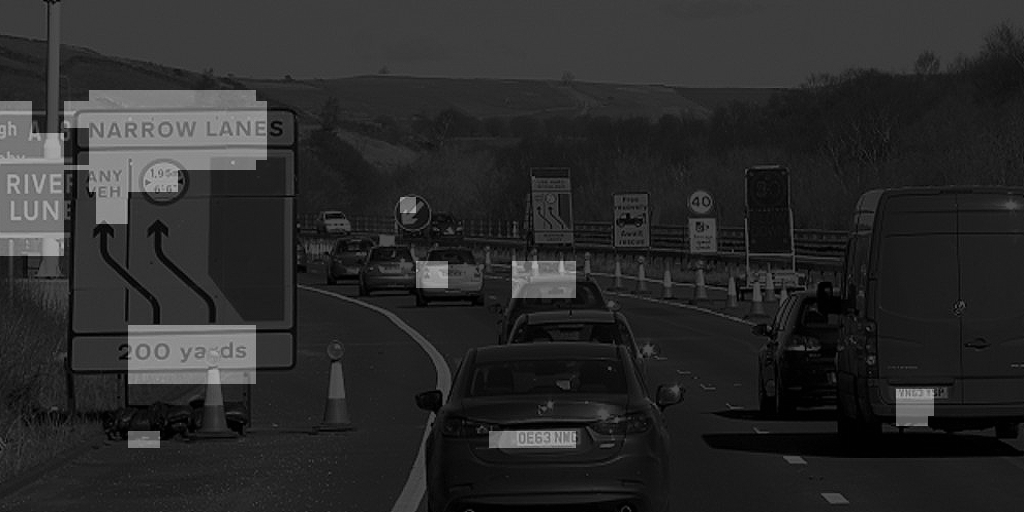

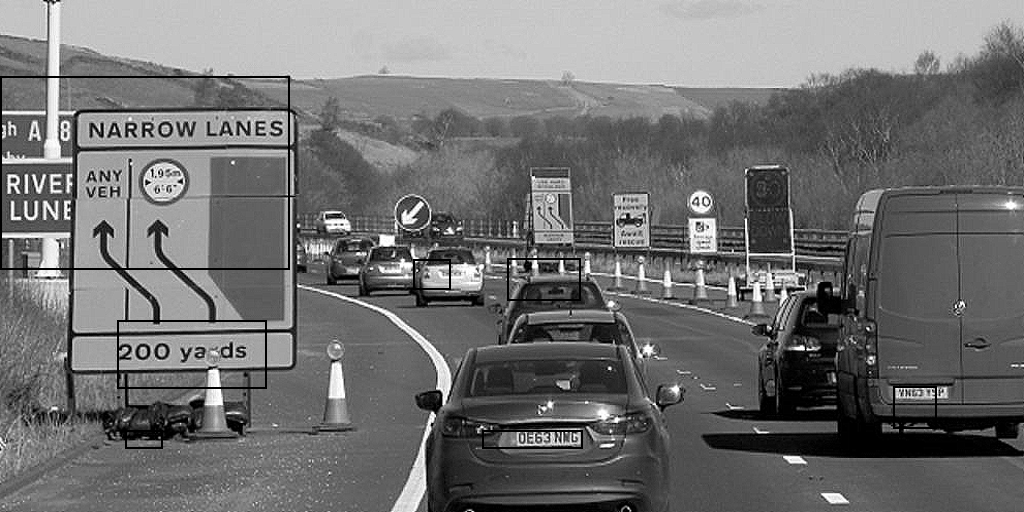

In [73]:
#tlist = [37, 32, 31, 30, 14, 12, 10]
#for x in tlist:

with Image.open(f"testimgs\\t12.png") as f:
    imo = btk.sharpen(btk.grey_np(f))
mtrx = heat_mapper(imo, (64, 64), 0.8)
im = np.invert(imo)
mtrx += heat_mapper(im, (64, 64), 0.8)
im = cv.adaptiveThreshold(imo, 254, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 19, 30)
mtrx += heat_mapper(im, (64, 64), 0.95)

nmtrx = mtrx.copy()
emtrx = np.array(nmtrx, dtype='uint8')
emtrx = cv.erode(emtrx, (9, 9), iterations=5)

emtrx[emtrx < mtrx.max() * 0.4] = 0
emtrx[emtrx > 0] = 127

im = btk.fit2dims(imo, (64, 64))
combined = cv.addWeighted(im, 0.3, emtrx, 0.7, 1)
display(Image.fromarray(combined))
bounds = text_bounds(emtrx, im)

(18, 100)

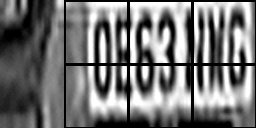

32768

[(array([  0,  64,  64, 128], dtype=uint16), 0.96150553),
 (array([  0,  64, 128, 192], dtype=uint16), 0.9960361),
 (array([  0,  64, 192, 256], dtype=uint16), 0.81550825),
 (array([ 64, 128,  64, 128], dtype=uint16), 0.93973136),
 (array([ 64, 128, 128, 192], dtype=uint16), 0.99229866),
 (array([ 64, 128, 192, 256], dtype=uint16), 0.9942859)]

(18, 37)

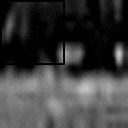

16384

[(array([ 0, 64,  0, 64], dtype=uint16), 0.8167248)]

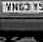

(42, 43)

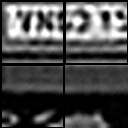

16384

[(array([ 0, 64,  0, 64], dtype=uint16), 0.99831617),
 (array([  0,  64,  64, 128], dtype=uint16), 0.9970913),
 (array([ 64, 128,   0,  64], dtype=uint16), 0.8125773)]

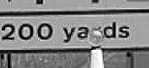

(68, 149)

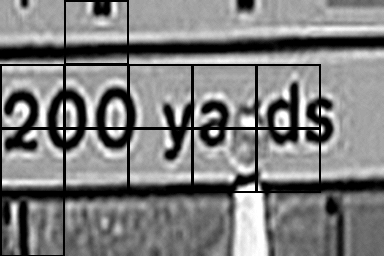

98304

[(array([  0,  64,  64, 128], dtype=uint16), 0.9904122),
 (array([ 64, 128,   0,  64], dtype=uint16), 0.9999796),
 (array([ 64, 128,  64, 128], dtype=uint16), 0.9998192),
 (array([ 64, 128, 128, 192], dtype=uint16), 0.999894),
 (array([ 64, 128, 192, 256], dtype=uint16), 0.9916544),
 (array([ 64, 128, 256, 320], dtype=uint16), 0.99888915),
 (array([128, 192,   0,  64], dtype=uint16), 0.99770504),
 (array([128, 192,  64, 128], dtype=uint16), 0.9993693),
 (array([128, 192, 128, 192], dtype=uint16), 0.97525567),
 (array([128, 192, 192, 256], dtype=uint16), 0.9798313),
 (array([128, 192, 256, 320], dtype=uint16), 0.9959488),
 (array([192, 256,   0,  64], dtype=uint16), 0.94368625)]

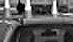

(42, 73)

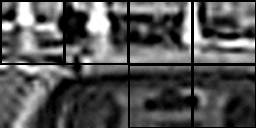

32768

[(array([ 0, 64,  0, 64], dtype=uint16), 0.81817925),
 (array([  0,  64,  64, 128], dtype=uint16), 0.9225271),
 (array([  0,  64, 128, 192], dtype=uint16), 0.9823501),
 (array([  0,  64, 192, 256], dtype=uint16), 0.9367102),
 (array([ 64, 128, 128, 192], dtype=uint16), 0.920555),
 (array([ 64, 128, 192, 256], dtype=uint16), 0.8518645)]

(30, 37)

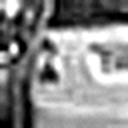

16384

[]

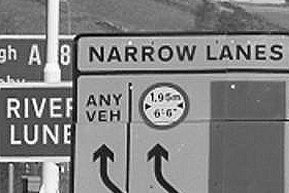

(193, 289)

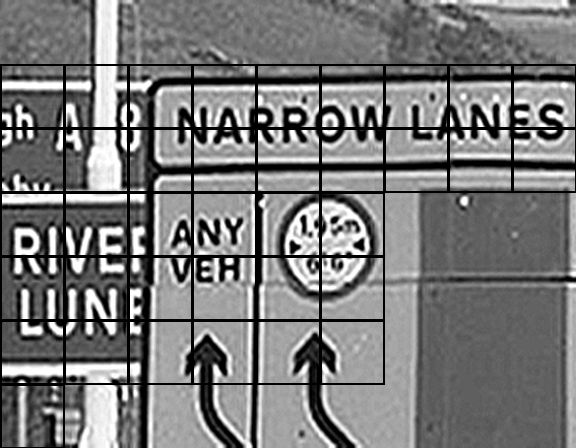

258048

[(array([ 64, 128,   0,  64], dtype=uint16), 0.9989373),
 (array([ 64, 128,  64, 128], dtype=uint16), 0.950225),
 (array([ 64, 128, 128, 192], dtype=uint16), 0.98940384),
 (array([ 64, 128, 192, 256], dtype=uint16), 0.9999831),
 (array([ 64, 128, 256, 320], dtype=uint16), 0.9996556),
 (array([ 64, 128, 320, 384], dtype=uint16), 0.99999666),
 (array([ 64, 128, 384, 448], dtype=uint16), 0.9973615),
 (array([ 64, 128, 448, 512], dtype=uint16), 0.99993587),
 (array([ 64, 128, 512, 576], dtype=uint16), 0.9947718),
 (array([128, 192,   0,  64], dtype=uint16), 0.9152831),
 (array([128, 192,  64, 128], dtype=uint16), 0.99117696),
 (array([128, 192, 128, 192], dtype=uint16), 0.9948986),
 (array([128, 192, 192, 256], dtype=uint16), 0.9999995),
 (array([128, 192, 256, 320], dtype=uint16), 0.99999774),
 (array([128, 192, 320, 384], dtype=uint16), 0.9998317),
 (array([128, 192, 384, 448], dtype=uint16), 0.998467),
 (array([128, 192, 448, 512], dtype=uint16), 0.9998908),
 (array([128, 192, 512, 576]

In [91]:
ext = extractor(im, bounds)
full_results = []

for x in ext:
    display(Image.fromarray(x))
    display(x.shape)
    x = cv.GaussianBlur(x, (3, 3), 3)
    x = btk.sharpen(x)
    x = btk.fit2dims(x, (64, 64))

    x = cv.GaussianBlur(x, (3, 3), 3)
    x = btk.sharpen(x)
    sc_coeff = (x.shape[0] * x.shape[1] * 3 / x.size)**0.5
    x = btk.resize(x, (round(x.shape[0] * sc_coeff), round(x.shape[1] * sc_coeff)))
    x = btk.fit2dims(x, (64, 64))

    x = cv.GaussianBlur(x, (3, 3), 3)
    x = btk.sharpen(x)
    results = scaling_handler(x, (64, 64), x.shape[0] * x.shape[1], 0.8, prnt=True)
    display(x.size)
    if sum([y[1] for y in results]) > 0.25 * x.size / 4096:
        full_results.append((x, results))
    #results = [x for x in results if sum([y[1] for y in x]) > 0.25 * len(results)] 
    #x = cv.adaptiveThreshold(x, 254, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 7, 7)
    #results = fast_tcheck(x, (64, 64), 0, True)
    display(results)
    #display(check)

#ext = [x for i, x in enumerate(ext) if sum([y[1] for y in full_results[i]])] 


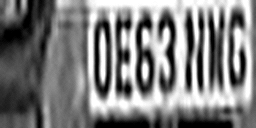

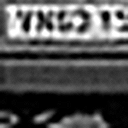

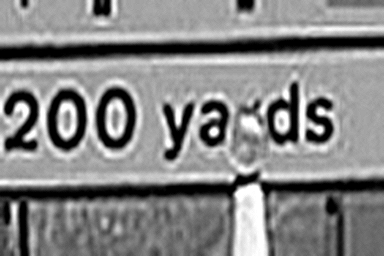

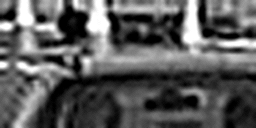

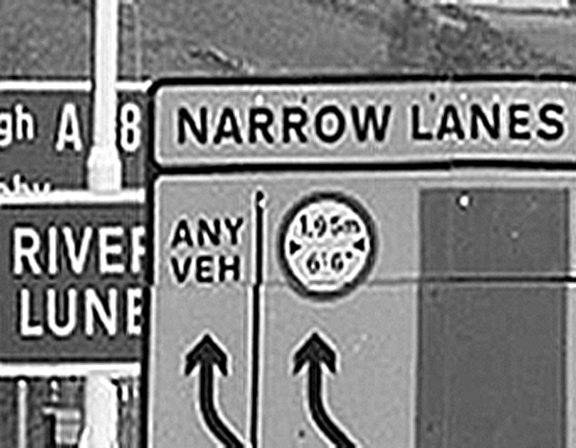

In [102]:
for x in full_results:
    x = x[0]
    #x = btk.resize(x, (round(x.shape[0] * 3), round(x.shape[1] * 3)))
    #x = cv.GaussianBlur(x, (3, 3), 3)
    #x = btk.sharpen(x)
    #x = cv.adaptiveThreshold(x, 254, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 7, 5)
    display(Image.fromarray(x))